# Basemap with GEDI and ICESat-2 footprints plot

## Part of the scripts were adapted from Sliderule tutorials available at: 

https://slideruleearth.io/web/rtd/tutorials/user.html 

https://slideruleearth.io/web/rtd/getting_started/Examples.html

## 1. Initiate Sliderule and define input and output directories

In [ ]:
import sliderule
from sliderule import icesat2, gedi, earthdata
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

import rasterio
from rasterio.plot import show
from skimage import exposure

In [4]:
icesat2.init("slideruleearth.io", verbose=True)
gedi.init("slideruleearth.io", verbose=True)
# earthdata.set_max_resources(10000)

In [5]:
# Directory where your area of interest .geojson is stored
dir_shp = ''
# Directory with the basemap image
dir_tifs = ''
# Directory where the output figures will be saved
dir_figures = ''

## 2. Upload area of interest geojason file

In [6]:
# Define path to the .geojson file
poly_fn =  os.path.join(dir_shp,'mg1_veg.geojson')
# Uploaded it  as a sliderule region
region = sliderule.toregion(poly_fn)
# print(region)

## 3. Get ICESat-2 tracks

In [7]:
# build sliderule parameters for ATL03 subsetting request
# SRT_LAND = 0
# SRT_OCEAN = 1
# SRT_SEA_ICE = 2
# SRT_LAND_ICE = 3
# SRT_INLAND_WATER = 4

# Define main parameters to extract
parms = {
    # processing parameters
    "srt": icesat2.SRT_LAND,
    "len": 20,
    # classification and checks
    # still return photon segments that fail checks
    "pass_invalid": True, 
    # all photons
    "cnf": -2, 
    # all land classification flags
    "atl08_class": ["atl08_noise", "atl08_ground", "atl08_canopy", "atl08_top_of_canopy", "atl08_unclassified"],
    # all photons
    "yapc": dict(knn=0, win_h=6, win_x=11, min_ph=4, score=0)
}

# Define ICESat-2 data release
release = '005'
# Define region of interest
poly = region["poly"]

# Define time bounds for CMR query
time_start = '2019-11-14'
time_end = '2019-11-15'


# Search  granule for the region of interest
granules_list = earthdata.cmr(short_name='ATL03', 
                              polygon=poly, 
                              time_start=time_start, 
                              time_end=time_end, 
                              version=release)

# create an empty geodataframe
parms["poly"] = poly

In [8]:
%%time
# create an empty geodataframe
icesat_tracks = icesat2.atl03sp(parms, resources=granules_list)

CPU times: total: 7.5 s
Wall time: 14 s


In [11]:
# Print head of the geodatafrabe
# icesat_tracks.head()

## 4. Get GEDI tracks

In [12]:
# Define GEDI L4A Request Parameters
parms = {
    "poly": region["poly"],
    "degrade_flag": 0,
    "l2_quality_flag": 1
    # "beam": 0 #"beam": -1 # "-1" means all beams
}

In [13]:
# Request GEDI Data
# gedi04a = gedi.gedi04ap(parms, resources=['GEDI04_A_2019123154305_O02202_03_T00174_02_002_02_V002.h5'])
gedi04a = gedi.gedi04ap(parms)
                        

print("Received {} footprints".format(gedi04a.shape[0]))
if len(gedi04a) > 0:
    print("Beams: {}".format(gedi04a["beam"].unique()))

Received 125 footprints
Beams: [6 5 0 8 3 2]


In [14]:
# Define the beam values you want to filter
# # Filterting power beams
power_beams = [5, 6, 8, 11]

# Use boolean indexing to filter rows with the specified beam values
gedi04a_powerbeans = gedi04a[gedi04a['beam'].isin(power_beams)]

## 5. Plot Icesat and GEDI together with a basemap

<Axes: >

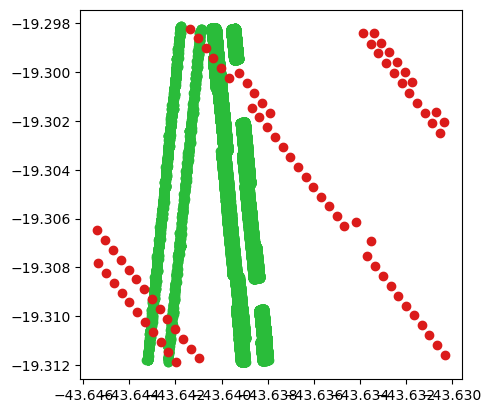

In [12]:
# Plot the first GeoDataFrame ('gdf') with a specified color (e.g., blue)
icesat_tracks.plot(ax=plt.gca(), color='#2ABC3A')

# Plot the second GeoDataFrame ('icesat2_track') with a different color (e.g., red)
gedi04a_powerbeans.plot(ax=plt.gca(), color='#DB1B1A')

In [43]:
# # Get metric scale for the map
# from matplotlib_scalebar.scalebar import ScaleBar
# # Define the EPSG code for UTM zone 23S
# epsg_code = 32723


# # Convert GeoDataFrames to EPSG 32723
# icesat_tracks_utm = icesat_tracks.to_crs(epsg=epsg_code)
# gedi04a_powerbeans_utm = gedi04a_powerbeans.to_crs(epsg=epsg_code)



# # Get the bounding box (extent) of the gedi04a_powerbeans GeoDataFrame
# gedi04a_extent = gedi04a_powerbeans_utm.total_bounds

# # Set axis limits to match the bounding box of gedi04a_powerbeans
# plt.xlim(gedi04a_extent[0], gedi04a_extent[2])
# plt.ylim(gedi04a_extent[1], gedi04a_extent[3])



# # Create a plot
# fig, ax = plt.subplots(figsize=(10, 10))

# # Plot the first GeoDataFrame ('icesat_tracks_utm') with a specified color (e.g., blue)
# icesat_tracks_utm.plot(ax=ax, color='#2ABC3A', label='ICESat Tracks')

# # Plot the second GeoDataFrame ('gedi04a_powerbeans_utm') with a different color (e.g., red)
# gedi04a_powerbeans_utm.plot(ax=ax, color='#DB1B1A', label='GEDI04A Power Beans')

# ax.add_artist(ScaleBar(1))


# # Set the width, height, and DPI for the exported image
# fig = plt.gcf()
# fig.set_size_inches(2.5, 2.5)
# fig.set_dpi(300)


# # SAVE FIGURE
# # Export the plot as a TIFF image
# scale_path = os.path.join(dir_figures,'GediIcesat','scale_meters.tif') 

# fig.savefig(scale_path, 
#             dpi=300, bbox_inches='tight', format='tiff')
# # Display the plot
# plt.show()

## 6. Plot  footprints with single band image basemap and export it

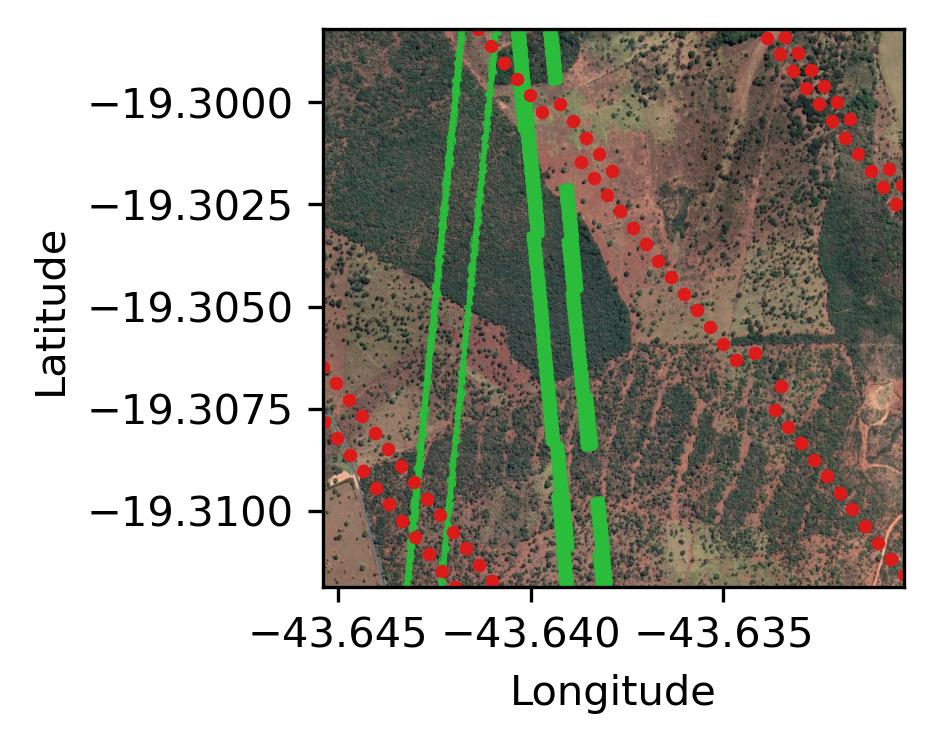

In [15]:
import rasterio
from rasterio.plot import show
from skimage import exposure


# Get the bounding box (extent) of the gedi04a_powerbeans GeoDataFrame
gedi04a_extent = gedi04a_powerbeans.total_bounds

# Set axis limits to match the bounding box of gedi04a_powerbeans
plt.xlim(gedi04a_extent[0], gedi04a_extent[2])
plt.ylim(gedi04a_extent[1], gedi04a_extent[3])

# Basemap path
basemap_path = os.path.join(dir_tifs,'aoi_wgs.tif')

# Open the raster file using the path stored in basemap_path
with rasterio.open(basemap_path) as src:
    # Plot the raster
    show(src, ax=plt.gca(), alpha=1)  # Set alpha to make the raster semi-transparent
    
# Plot the first GeoDataFrame ('icesat_tracks') with a specified color (e.g., blue)
icesat_tracks.plot(ax=plt.gca(), color='#2ABC3A', markersize=0.1)

# Plot the second GeoDataFrame ('gedi04a_powerbeans') with a different color (e.g., red)
gedi04a_powerbeans.plot(ax=plt.gca(), color='#DB1B1A',markersize=5)

# Add X and Y titles
plt.xlabel('Longitude')
plt.ylabel('Latitude')


# Set the width, height, and DPI for the exported image
fig = plt.gcf()
fig.set_size_inches(2.5, 2.5)
fig.set_dpi(300)

# Show the plot
plt.show()

# Export the plot as a TIFF image
basemap_path = os.path.join(dir_figures,'GediIcesat','basemap.tif') 

fig.savefig(basemap_path, 
            dpi=300, bbox_inches='tight', format='tiff')

## 7. Plot  footprints with three band (RGB) image basemap and export it

C:\Users\rvieiral\AppData\Local\anaconda3\envs\developer_sliderule\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


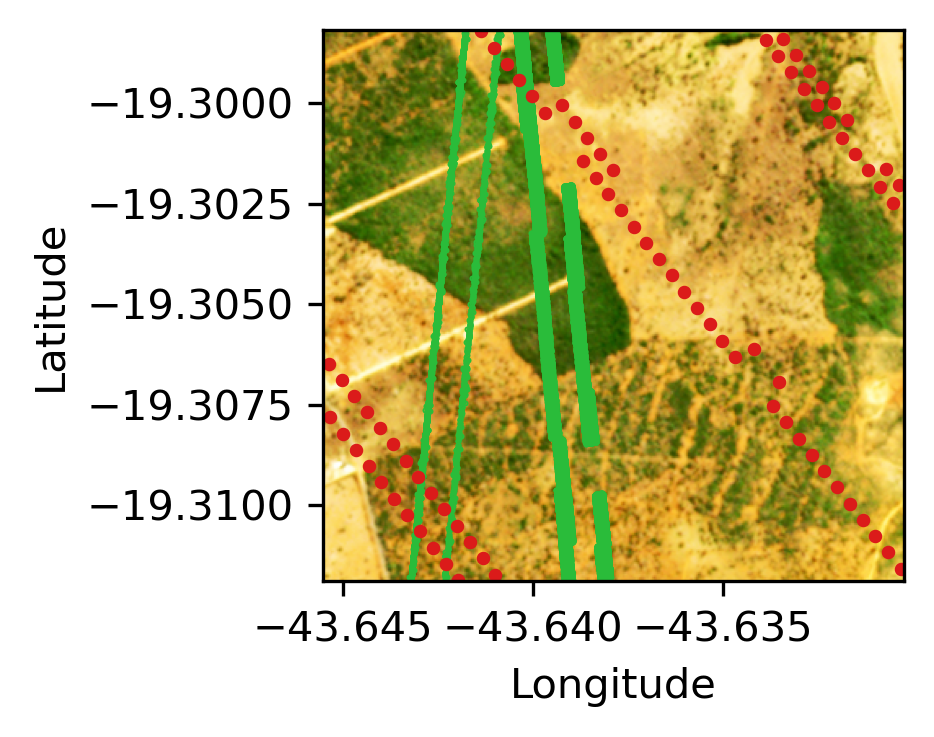

In [16]:
### Define the path to the TIFF file
basemap_path = os.path.join(dir_tifs, 'aoi_fireEO.tif')

# Open the raster file using the path stored in basemap_path
with rasterio.open(basemap_path) as src:
    # Read the individual bands (B, G, R, N)
    b_band = src.read(1)
    g_band = src.read(2)
    r_band = src.read(3)

    # Combine the bands to create an RGB image
    rgb_image = np.dstack((r_band, g_band, b_band))

    # Apply histogram equalization to improve contrast
    equalized_image = exposure.equalize_hist(rgb_image)

    # Plot the equalized RGB image
    plt.imshow(equalized_image, extent=(src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top))

# Plot the first GeoDataFrame ('icesat_tracks') with a specified color (e.g., blue)
icesat_tracks.plot(ax=plt.gca(), color='#2ABC3A', markersize=0.2)

# Plot the second GeoDataFrame ('gedi04a_powerbeans') with a different color (e.g., red)
gedi04a_powerbeans.plot(ax=plt.gca(), color='#DB1B1A', markersize=5)

# Add X and Y titles
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Format X and Y axis labels to one decimal place
plt.gca()#.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.gca()#.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# Set the width, height, and DPI for the exported image
fig = plt.gcf()
fig.set_size_inches(2.5, 2.5)
fig.set_dpi(300)

# Show the plot
plt.show()

# Export the plot as a TIFF image
output_path = os.path.join(dir_figures, 'GediIcesat', 'basemap.tif')
fig.savefig(output_path, dpi=300, bbox_inches='tight', format='tiff')